### Libraries

In [1]:
library( rpart )
library( caret )
library( Amelia )

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.4, built: 2015-12-05)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 


### Data

In [2]:
df <- read.csv( '../data/processed/employee-transportationdata.csv' )

In [3]:
str( df )

'data.frame':	3838 obs. of  6 variables:
 $ Employee.ID       : int  649 991 611 791 1247 3261 1224 1074 779 250 ...
 $ GENDER            : Factor w/ 3 levels "F","M","U": 1 2 1 2 2 1 1 2 2 2 ...
 $ Age               : int  31 53 37 41 87 34 65 70 41 52 ...
 $ MARITAL.STATUS    : Factor w/ 2 levels "M","S": 2 2 2 2 1 2 1 2 2 2 ...
 $ DriveDistanceMiles: num  0.34 0.41 0.49 0.5 0.5 0.53 0.61 0.67 0.76 0.85 ...
 $ Mode              : Factor w/ 3 levels "Bike","Car","Public Transportation": 2 3 1 1 3 1 3 3 1 2 ...


### Decision tree model

### Check for missing data

In [ ]:
# missmap( df )

Annoyingly complete...

### Partition the data

In [4]:
train <- createDataPartition( df$Mode, 1, p = 0.6, list = FALSE )

In [5]:
df.train <- df[train,]

In [6]:
df.test <- df[-train,]

In [7]:
nrow( df.train);nrow( df.test)

[1] 2304

[1] 1534

### Decision tree model

In [8]:
fit.tree <- rpart( Mode
     ~ GENDER
     + Age
     + MARITAL.STATUS
     + DriveDistanceMiles
     , data = df.train )

In [9]:
pred <- predict( fit.tree, df.test )

In [10]:
predictions <- cbind( df.test$Mode, pred )

In [11]:
df.test <- cbind( df.test, predictions )

In [18]:
names( df.test ) <- c("Employee.ID", "GENDER", "Age", "MARITAL.STATUS", "DriveDistanceMiles", 
"Mode", "V1", "Bike", "Car", "Public_Transportation")

In [19]:
df.test <- within( df.test, {
    pred = NA
    pred[Bike > 0.5] = 1
    pred[Car > 0.5] = 2
    pred[Public_Transportation > 0.5] = 3
})

In [20]:
confusionMatrix( df.test$V1, df.test$pred )

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3
         1 129   0   0
         2  15 895  42
         3   8  70 375

Overall Statistics
                                          
               Accuracy : 0.912           
                 95% CI : (0.8967, 0.9257)
    No Information Rate : 0.6291          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8311          
 Mcnemar's Test P-Value : 1.38e-06        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Sensitivity           0.84868   0.9275   0.8993
Specificity           1.00000   0.8998   0.9302
Pos Pred Value        1.00000   0.9401   0.8278
Neg Pred Value        0.98363   0.8797   0.9611
Prevalence            0.09909   0.6291   0.2718
Detection Rate        0.08409   0.5834   0.2445
Detection Prevalence  0.08409   0.6206   0.2953
Balanced Accuracy     0.92434   0.9136   0.9147

In [22]:
df.test <- df.test[,c(1:6,11)]

In [26]:
names( df.test ) <- c("Employee.ID", "GENDER", "Age", "MARITAL.STATUS", "DriveDistanceMiles", 
"Mode", "pred.dt")

### Random Forest model

In [27]:
library( randomForest )

Warning message:
“package ‘randomForest’ was built under R version 3.4.4”randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [28]:
fit.rf <- randomForest( Mode
                      ~ .
                      , data = df.train[, -1 ] )

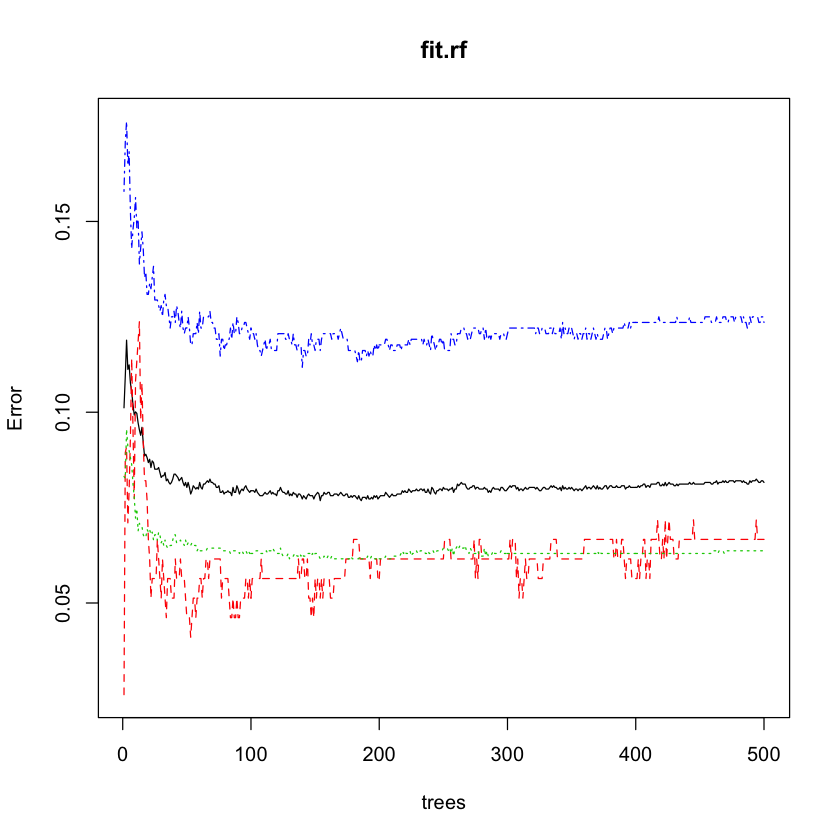

In [29]:
plot( fit.rf )

In [30]:
importance( fit.rf )

,MeanDecreaseGini
GENDER,12.66793
Age,414.17125
MARITAL.STATUS,15.84318
DriveDistanceMiles,622.73310


In [31]:
df.test$pred.rf <- predict( fit.rf, df.test )

In [33]:
head( df.test )

,Employee.ID,GENDER,Age,MARITAL.STATUS,DriveDistanceMiles,Mode,pred.dt,pred.rf
1,649,F,31,S,0.34,Car,1,Bike
4,791,M,41,S,0.50,Bike,1,Bike
5,1247,M,87,M,0.50,Public Transportation,3,Car
6,3261,F,34,S,0.53,Bike,1,Bike
8,1074,M,70,S,0.67,Public Transportation,3,Public Transportation
9,779,M,41,S,0.76,Bike,1,Bike


In [34]:
confusionMatrix( df.test$Mode, df.test$pred.rf )

Confusion Matrix and Statistics

                       Reference
Prediction              Bike Car Public Transportation
  Bike                   123   6                     0
  Car                     15 887                    50
  Public Transportation    6  57                   390

Overall Statistics
                                          
               Accuracy : 0.9126          
                 95% CI : (0.8974, 0.9263)
    No Information Rate : 0.6193          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.833           
 Mcnemar's Test P-Value : 0.01607         

Statistics by Class:

                     Class: Bike Class: Car Class: Public Transportation
Sensitivity              0.85417     0.9337                       0.8864
Specificity              0.99568     0.8887                       0.9424
Pos Pred Value           0.95349     0.9317                       0.8609
Neg Pred Value           0.98505   

In [35]:
table( df.test$pred.rf )


                 Bike                   Car Public Transportation 
                  144                   950                   440 